<a href="https://colab.research.google.com/github/SP-2-Red-Data-Mining-and-AI/solid-bassoon/blob/main/LA_CrimeAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

from sklearn.decomposition import PCA

from scipy.stats import gaussian_kde

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

import plotly.graph_objects as go

import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from folium.plugins import TimestampedGeoJson
from folium.plugins import HeatMapWithTime

from IPython.display import IFrame
from IPython.display import display
from IPython.display import HTML
from ipywidgets import IntProgress

from abc import ABC, abstractmethod

In [ ]:
#some useful functions for allowing pandas dataframes to be fully displayed
def pandas_unlimited_output():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.expand_frame_repr', False)

def pandas_default_output():
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.max_colwidth')
    pd.reset_option('display.expand_frame_repr')


In [ ]:
#abstract data manager class
class DataManager(ABC):

    def __init__(self):
        self.raw_data = self.load_raw_data()
        self.clean_data()

    @abstractmethod
    def load_raw_data(self):
        pass

    @abstractmethod
    def clean_data(self):
        pass

    @abstractmethod
    def get_data_in_range(self):
        pass

    @abstractmethod
    def get_transactions(self):
        pass

In [ ]:
#handles the la dataset, functions tailored to work with it
class LADataManager(DataManager):

    def load_raw_data(self, print_cols = False):

        dataset_name = 'Crime_data_from_2020_to_Present.csv'
        raw_data = pd.read_csv(dataset_name)

        #from crime desc, weapon desc, and premis desc, remove portions contained in parentheses
        raw_data['Crm Cd Desc'] = raw_data['Crm Cd Desc'].str.replace(r"\(.*\)","")
        raw_data['Weapon Desc'] = raw_data['Weapon Desc'].str.replace(r"\(.*\)","")
        raw_data['Premis Desc'] = raw_data['Premis Desc'].str.replace(r"\(.*\)","")

        #create tables for crime, weapon, and premises descriptions along with their code
        #find the desc for each cd, dont include original index
        crime_desc = raw_data[['Crm Cd', 'Crm Cd Desc']].drop_duplicates().reset_index(drop=True).sort_values(by='Crm Cd').set_index('Crm Cd')
        weapon_desc = raw_data[['Weapon Used Cd', 'Weapon Desc']].drop_duplicates().reset_index(drop=True).sort_values(by='Weapon Used Cd')
        premis_desc = raw_data[['Premis Cd', 'Premis Desc']].drop_duplicates().reset_index(drop=True).sort_values(by='Premis Cd')

        #drop codes with nan descriptions
        crime_desc = crime_desc.dropna()
        weapon_desc = weapon_desc.dropna()
        premis_desc = premis_desc.dropna()

        self.weapon_desc_dict = weapon_desc.set_index('Weapon Used Cd').to_dict()['Weapon Desc']
        self.crime_desc_dict = crime_desc.to_dict()['Crm Cd Desc']
        self.premis_desc_dict = premis_desc.set_index('Premis Cd').to_dict()['Premis Desc']

        if print_cols:
            print(raw_data.columns)

        return raw_data

    #processes the raw data into a dataframe filled with normalized and encoded data
    def clean_data(self):
        #take only the columns we need:
        #DATE OCC, TIME OCC, Crm Cd, Weapon Used Cd, Premis Cd, LAT, LON

        #drop raw data rows where Premis Desc is nan
        self.raw_data = self.raw_data.dropna(subset=['Premis Desc'])

        data = self.raw_data[['DATE OCC', 'TIME OCC', 'Crm Cd', 'Weapon Used Cd', 'Premis Cd', 'LAT', 'LON']].copy()

        df_crime_cd_desc_labels = pd.read_excel('crime_cd_desc_labels.xlsx')
        self.crime_cd_desc_map = df_crime_cd_desc_labels.set_index('Crm Cd').to_dict(orient='index')

        df_premis_cd_desc_labels = pd.read_csv('premis_desc_dict.csv')
        self.premis_cd_desc_map = df_premis_cd_desc_labels.set_index('Premis Cd').to_dict(orient='index')

        #create a new column for the primary and secondary crime labels
        data['Crm Primary'] = data['Crm Cd'].map(lambda x: self.crime_cd_desc_map[x]['Crm Primary'])
        data['Crm Secondary'] = data['Crm Cd'].map(lambda x: self.crime_cd_desc_map[x]['Crm Secondary'])

        #process time data to be a single datetime column
        data['DATE OCC'] = pd.to_datetime(data['DATE OCC'])
        data['TIME OCC'] = data['TIME OCC'].apply(lambda x: str(x).zfill(4))

        data['datetime'] = pd.to_datetime(data['DATE OCC']) \
            + pd.to_timedelta(data['TIME OCC'].apply(lambda x: int(x[:2])), unit='h') \
            + pd.to_timedelta(data['TIME OCC'].apply(lambda x: int(x[2:])), unit='m')

        data.drop(columns=['DATE OCC', 'TIME OCC'], inplace=True)

        #time feaures to extract:
        #day of week (cyclical)
        #hour of day (cyclical)
        #month of year (cyclical)
        #year normalized

        #hour of day
        data['hour_sin'] = np.sin(2 * np.pi * data['datetime'].dt.hour / 24)
        data['hour_cos'] = np.cos(2 * np.pi * data['datetime'].dt.hour / 24)
        data['hour'] = data['datetime'].dt.hour

        #day of week
        data['day_of_week_sin'] = np.sin(2 * np.pi * data['datetime'].dt.dayofweek / 7)
        data['day_of_week_cos'] = np.cos(2 * np.pi * data['datetime'].dt.dayofweek / 7)
        data['day_of_week'] = data['datetime'].dt.dayofweek

        #month of year
        data['month_sin'] = np.sin(2 * np.pi * data['datetime'].dt.month / 12)
        data['month_cos'] = np.cos(2 * np.pi * data['datetime'].dt.month / 12)
        data['month'] = data['datetime'].dt.month

        #day of year
        data['day_of_year_sin'] = np.sin(2 * np.pi * data['datetime'].dt.dayofyear / 365)
        data['day_of_year_cos'] = np.cos(2 * np.pi * data['datetime'].dt.dayofyear / 365)
        data['day_of_year'] = data['datetime'].dt.dayofyear

        #year
        year_scaler = MinMaxScaler()
        data['year'] = year_scaler.fit_transform(data['datetime'].dt.year.values.reshape(-1, 1))

        #drop the 10 rows where premis cd is nan
        data = data.dropna(subset=['Premis Cd'])

        #where weapon used cd is nan, replace with 0
        data['Weapon Used Cd'] = data['Weapon Used Cd'].fillna(0)
        self.weapon_desc_dict[0] = 'No Weapon Used'

        #make a new column 'weapon_exists' that is 1 if weapon used cd is not 0, else 0
        data['weapon_exists'] = data['Weapon Used Cd'].apply(lambda x: 1 if x != 0 else 0)

        #drop lat or lon vals that are 0
        data = data[(data['LAT'] != 0) & (data['LON'] != 0)]

        #normalize data
        scaler = MinMaxScaler()

        la_coords = (34.0522, -118.2437)

        #drop where lat or lon is more than 1 away from LA
        data = data[(data['LAT'] > la_coords[0] - 1) & (data['LAT'] < la_coords[0] + 1) & (data['LON'] > la_coords[1] - 1) & (data['LON'] < la_coords[1] + 1)]

        data['LAT'] = scaler.fit_transform(data['LAT'].values.reshape(-1, 1))
        self.lat_scaler = (scaler.data_min_, scaler.data_max_)

        data['LON'] = scaler.fit_transform(data['LON'].values.reshape(-1, 1))
        self.lon_scaler = (scaler.data_min_, scaler.data_max_)

        data['year'] = scaler.fit_transform(data['year'].values.reshape(-1, 1))
        self.year_scaler = (scaler.data_min_, scaler.data_max_)

        #encode categorical data and normalize
        cols_to_encode = ['Crm Cd', 'Weapon Used Cd', 'Premis Cd']
        for col in cols_to_encode:
            new_col_name = col + '_freq'
            freq_map = data[col].value_counts().to_dict()
            data[new_col_name] = data[col].map(freq_map)
            data[new_col_name] = scaler.fit_transform(data[new_col_name].values.reshape(-1, 1))

        data['Premis Primary'] = data['Premis Cd'].map(lambda x: self.premis_cd_desc_map[x]['Primary'])
        data['Premis Secondary'] = data['Premis Cd'].map(lambda x: self.premis_cd_desc_map[x]['Secondary'])

        self.data = data

    def get_data_in_range(self, start_date, end_date):
        return self.data[(self.data['datetime'] >= start_date) & (self.data['datetime'] <= end_date)]

    #for use with association data mining, transactions are a list of lists of strings (or discrete values) that occur together
    #returns a pd dataframe, for use in the association mining method, first apply values.tolist() to the dataframe
    def get_transactions(self, data):

        #discretize datetime into 6 hour intervals for time of day, day of week, and month
        #time of day: 9pm-3am night, 3am-9am morning, 9am-3pm noon, 3pm-9pm evening
        data['time_of_day'] = pd.cut(data['datetime'].dt.hour, bins=[0, 3, 9, 15, 21, 24], labels=['night', 'morning', 'noon', 'evening', 'night'], ordered=False)
        data['day_of_week'] = data['datetime'].dt.dayofweek
        data['month'] = data['datetime'].dt.month

        transactions = data[['Crm Cd', 'Crm Primary', 'Crm Secondary', 'Weapon Used Cd', 'Premis Cd', 'Premis Primary', 'Premis Secondary', 'time_of_day', 'day_of_week', 'month']].copy()

        #convert cluster labels to string as "Cluster " + cluster_label
        if('cluster_label' in data.columns):
            transactions['cluster_label'] = data['cluster_label'].apply(lambda x: 'Cluster ' + str(x))

        #convert columns to string
        #use lookup tables for cd columns
        transactions['Crm Cd'] = transactions['Crm Cd'].map(self.crime_desc_dict)
        transactions['Weapon Used Cd'] = transactions['Weapon Used Cd'].map(self.weapon_desc_dict)
        transactions['Premis Cd'] = transactions['Premis Cd'].map(self.premis_desc_dict)

        months_of_year = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        days_of_week = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

        transactions['month'] = transactions['month'].map(months_of_year)
        transactions['day_of_week'] = transactions['day_of_week'].map(days_of_week)

        transactions = transactions.astype(str)

        transactions = transactions.replace('nan', np.nan).dropna()

        return transactions

    def denormalize_lat_lon(self, data):
        #data is a numpy array with columns lat, lon
        #returns a numpy array with columns lat, lon
        lat_min, lat_max = self.lat_scaler
        lon_min, lon_max = self.lon_scaler

        data[:, 0] = data[:, 0] * (lat_max - lat_min) + lat_min
        data[:, 1] = data[:, 1] * (lon_max - lon_min) + lon_min
        return data


In [ ]:
#methods for processing data, independent of dataset

#clusters the given data using kmeans by the given columns
#columns for clustering should be continuous and normalized
#returns a new dataframe with a new column 'cluster_label' that contains the cluster label for each row as well as the cluster model
def cluster_kmeans(data, cluster_columns, cluster_count):

    X = data[cluster_columns]

    kmeans = KMeans(n_clusters=cluster_count, init='k-means++', max_iter=300, n_init=10, random_state=0)
    clusters = kmeans.fit_predict(X)

    data['cluster_label'] = clusters

    return data, kmeans

#takes awhile,  for just 2021 slice: eps = 0.1, min_samples = 10 ~6 min
#min samples affects the number of clusters, eps affects the size of the clusters
def cluster_DBSCAN(data, cluster_columns, eps, min_samples):

    X = data[cluster_columns]

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(X)

    data['cluster_label'] = clusters

    return data, dbscan

def cluster_agglomerative(data, cluster_columns, cluster_count):

    X = data[cluster_columns]

    agg = AgglomerativeClustering(n_clusters=cluster_count)
    clusters = agg.fit_predict(X)

    data['cluster_label'] = clusters

    return data, agg

#depending on size of transactions, this might take a while
#returns a dataframe of association rules from the given transactions list
def association_mining(transactions, min_support = 0.01, min_threshold = 0.5, metric = 'lift'):

    transactions = transactions.values.tolist()

    #create the encoder
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)

    #run apriori
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)

    #run association rules
    rules = association_rules(frequent_itemsets, metric=metric, min_threshold=min_threshold)

    return rules

#returns a new dataframe reduced via PCA based on the given columns and number of components
#columns used should be continuous and normalized
def get_pca(data, n_components, columns):

    pca_features = data[columns]

    scaler = StandardScaler()
    pca_features_scaled = scaler.fit_transform(pca_features)

    pca = PCA(n_components = n_components)
    X_pca = pca.fit_transform(pca_features_scaled)

    return X_pca, pca

#samples a given fraction of the data and calculates the gaussian kde
#returns the sampled data and the density values
def get_gaussian_kde(data, cols, sample_frac, log=False):

    assert len(cols) == 2 or len(cols) == 3, 'cols must be a list of 2 or 3 column names'

    #time complexity of gaussian_kde is O(N^2 * D) where N is the number of points and D is the number of dimensions
    #at 0.01 sample frac and 3 dimensions, it takes roughly 4 seconds
    #to do the entire dataset in 3 dimensions, it would take 4 * 100^2 = 40000 seconds = ~11 hours

    data_sampled = data.sample(frac=sample_frac).reset_index(drop=True)

    if len(cols) == 2:
        xyz = np.vstack([data_sampled[cols[0]], data_sampled[cols[1]]])
    elif len(cols) == 3:
        xyz = np.vstack([data_sampled[cols[0]], data_sampled[cols[1]], data_sampled[cols[2]]])

    if log: print('begining density calculation')
    density = gaussian_kde(xyz)(xyz)
    if log: print('density calculation complete')

    return data_sampled, density

def get_crime_counts(data, column_to_count, freq='D'):
    return data.set_index('datetime')[column_to_count].resample(freq).count()

def process_association_rules(rules):
    #sort rules by lif
    modified = rules.sort_values(by='lift', ascending=False)
    #remove every other row
    modified = modified[::2]
    modified = modified.sort_values(by='leverage', ascending=False)

    #lift = associativity of antecedent and consequent, < 1 means they are less likely to occur together, > 1 means they are more likely to occur together
    #leverage = difference between observed frequency of antecedent and consequent together and what would be expected if they were independent, positive means they occur together more than expected
    #print ant, cons, lev, lift, conv
    #only print rows where lift distance from 1 is greater than 0.2
    print(modified[abs(modified['lift'] - 1) > 0.2][['antecedents', 'consequents', 'leverage', 'lift', 'conviction']])

In [ ]:
#VISUALIZATION FUNCTIONS

#plots the given data in 2d or 3d, with the given columns as x, y, and/or z
#optionally, c can be given as a column name to color the points by
def plot(data, columns, title, c=None, alpha=0.5, show=True, c_bar=True):

    two_dim = len(columns) == 2
    three_dim = len(columns) == 3

    assert two_dim or three_dim, 'columns must be a list of 2 or 3 column names'

    if two_dim:

        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        scatter = ax.scatter(data[columns[0]], data[columns[1]], s=50, alpha=0.5)

        if(c != None):
            scatter = ax.scatter(data[columns[0]], data[columns[1]], c=data[c], cmap='viridis', s=50, alpha=0.5)
            if c_bar: fig.colorbar(scatter, ax=ax, label=c)

        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])

    elif three_dim:

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(data[columns[0]], data[columns[1]], data[columns[2]], cmap='viridis', s=50, alpha=alpha)

        if(c != None):
            scatter = ax.scatter(data[columns[0]], data[columns[1]], data[columns[2]], c=data[c], cmap='viridis', s=50, alpha=0.5)
            if c_bar: fig.colorbar(scatter, ax=ax, label=c)

        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])
        ax.set_zlabel(columns[2])

    ax.set_title(title)
    plt.legend()
    if show: plt.show()

def cluster_plot(data, columns, title, show=True):

    two_dim = len(columns) == 2
    three_dim = len(columns) == 3

    assert two_dim or three_dim, 'columns must be a list of 2 or 3 column names'
    assert 'cluster_label' in data.columns, 'data must have a column named cluster_label'

    if two_dim:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        ax.scatter(data[columns[0]], data[columns[1]], c=data['cluster_label'], cmap='viridis', s=50, alpha=0.5)

        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])

    elif three_dim:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        ax.scatter(data[columns[0]], data[columns[1]], data[columns[2]], c=data['cluster_label'], cmap='viridis', s=50, alpha=0.5)

        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])
        ax.set_zlabel(columns[2])

    ax.set_title(title)
    if show: plt.show()

#creates an animated 3d plot of the given data
#this can take a while
def plot_3d_animation(data, x, y, z, title, x_label, y_label, z_label, c=None, c_label=None, frames = 12, elev=20, show=True):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(data[x], data[y], data[z], s=50, alpha=0.5)

    if(c != None):
        scatter = ax.scatter(data[x], data[y], data[z], c=data[c], cmap='viridis', s=50, alpha=0.5)

    if(c_label != None and c != None):
        fig.colorbar(scatter, ax=ax, label=c_label)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)

    def update(frame):
        ax.view_init(elev=elev, azim=frame)

    plt.legend()
    if show: plt.show()

    ani = FuncAnimation(fig, update, frames=np.arange(0, 360, 360/frames))
    ani.save(title + '_animation.mp4', writer='ffmpeg')

#produces a plot (2d or 3d) of the given columns from the data, colored by density
def density_plot(data, sample_frac, title, columns, show=True):
    two_dim = len(columns) == 2
    three_dim = len(columns) == 3
    assert two_dim or three_dim, 'columns must be a list of 2 or 3 column names'

    data_sampled, density = get_gaussian_kde(data, columns, sample_frac)

    #sort points by density, so densest points are plotted last
    idx = density.argsort()
    x, y, density = data_sampled[columns[0]][idx], data_sampled[columns[1]][idx], density[idx]

    if three_dim:
        z = data_sampled[columns[2]][idx]
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(x, y, z, c=density, cmap='viridis')

        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])
        ax.set_zlabel(columns[2])

    else:
        fig, ax = plt.subplots(1, 1, figsize=(10, 7))
        scatter = ax.scatter(x, y, c=density, cmap='viridis')

        ax.set_xlabel(columns[0])
        ax.set_ylabel(columns[1])

    #color bar to represent density
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('density')

    plt.title(title)
    if show: plt.show()

#these are used for finding optimal cluster parameters
#elbow method to find optimal number of clusters
def cluster_elbow_plot(data, cluster_columns, max_clusters = 10):

    X = data[cluster_columns]

    wcss = []

    for i in range(1, max_clusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

def silhouette_score_plot(data, cluster_columns, max_clusters = 10):

    X = data[cluster_columns]

    silhouette_scores = []

    for i in range(2, max_clusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        clusters = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, clusters))

    plt.plot(range(2, max_clusters), silhouette_scores)
    plt.title('Silhouette Score Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.show()

def nearest_neighbor_plot(data, cluster_columns, n_neighbors = 5):

    X = data[cluster_columns]
    neighbors = NearestNeighbors(n_neighbors=n_neighbors)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)

    # Sort distance values
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    plt.plot(distances)
    plt.xlabel('Points sorted by distance to nearest neighbor')
    plt.ylabel(f'{n_neighbors}th nearest neighbor distance')
    plt.title('k-Distance Graph')
    plt.show()

def plot_cyclical_density(data, freq, title, binNames=None, show=True,):

    assert freq in ['hour', 'day_of_week', 'month'], 'freq must be one of hour, day_of_week, or month'

    bin_map = {'hour': 24, 'day_of_week': 7, 'month': 12}

    counts = data.groupby(freq).size()
    counts.index = np.radians(counts.index * 360 / bin_map[freq])
    norm = plt.Normalize(counts.min(), counts.max())

    fig, ax = plt.subplots(figsize=(8,6), subplot_kw=dict(polar=True))
    ax.set_xticks(np.linspace(0, 2 * np.pi, bin_map[freq], endpoint=False))

    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('N')

    cmap = plt.get_cmap('viridis')
    ax.bar(
        counts.index, np.full_like(counts, fill_value=5),
        width=2 * np.pi / bin_map[freq], bottom=0.0, color = cmap(norm(counts.values))
    )

    tick_labels = range(bin_map[freq])
    ax.set_xticklabels(tick_labels)
    if binNames != None:
        ax.set_xticklabels(binNames)

    ax.set_yticklabels([])
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='horizontal', label='Count')
    plt.title(title)

    if show: plt.show()

def plot_geospatial(data, show=False, point_type='marker', radius=10, m=None, labels=[], colors=[]):
    #data is a np array of lat, lon pairs shape: (n, 2)
    #map focues at mean of data

    mean = (data.mean(axis=0), data.mean(axis=1))

    if len(labels) == 0 or len(labels) != data.shape[0]:
        labels = ['' for i in range(data.shape[0])]

    if len(colors) == 0:
        colors = ['red' for i in range(data.shape[0])]

    if m == None:
        m = folium.Map(location=[data[:,0].mean(), data[:,1].mean()], zoom_start=12)

    if point_type == 'heatmap':
        HeatMap(data, radius=radius).add_to(m)
    elif point_type == 'marker':
        #make markers with the specified label and
        markers = MarkerCluster()
        for i in range(data.shape[0]):
            folium.Marker([data[i, 0], data[i, 1]], popup=labels[i], icon=folium.Icon(color=colors[i])).add_to(markers)
        markers.add_to(m)
    elif point_type == 'transparent_marker':
        for i in range(data.shape[0]):
            folium.Circle([data[i, 0], data[i, 1]], radius=radius, color=colors[i], fill=True, fill_color=colors[i], fill_opacity=0.1, popup=labels[i]).add_to(m)

    if show: display(m)

    return m

def plot_pie(data, category, title, num_to_show=5,  show=True):
    #create a pie chart of the top crimes in the dataset
    #group all other crimes into 'Other' category
    num_categories = len(data[category].unique())

    top_crimes = data[category].value_counts()
    #top_crimes.index = top_crimes.index.map(dm.crime_desc_dict)
    other = top_crimes[num_to_show:].sum()
    top_crimes = top_crimes[:num_to_show]
    #append other to the end of top_crimes with the label 'Other'
    top_crimes['Other'] = other

    #reduce font size of pie chart labels
    plt.rcParams.update({'font.size': 8})

    plt.pie(top_crimes, labels=top_crimes.index, autopct='%1.1f%%')

    #change coloring of pie chart
    plt.gca().set_prop_cycle(None)
    plt.pie(top_crimes, labels=top_crimes.index, autopct='%1.1f%%', colors=plt.cm.tab20.colors)

    plt.title(title)
    if show:
        plt.show()

In [ ]:
date_first = '2020-01-01'
date_2021 = '2021-01-01'
date_2022 = '2022-01-01'
date_2023 = '2023-01-01'
date_last = '2024-02-05'

In [ ]:
dm = LADataManager()
print(dm.data.columns)

In [ ]:
csv_file_path = 'premis_desc_dict.csv'
premis_data_csv = pd.read_csv(csv_file_path, index_col=0)

categories = {
    "Transportation": {
        "Streets and Roads": ["STREET", "SIDEWALK", "ALLEY", "DRIVEWAY", "FREEWAY"],
        "Public Transit": ["BUS-CHARTER/PRIVATE", "BUS, SCHOOL, CHURCH", "TRUCK, COMMERICAL", "TAXI", "AIRCRAFT", "BUS STOP",
                           "TRAIN, OTHER THAN MTA (ALSO QUERY 809/810/811)", "BUS STOP/LAYOVER (ALSO QUERY 124)",
                           "TERMINAL, OTHER THAN MTA", "MTA PROPERTY OR PARKING LOT", "TRAM/STREETCAR(BOXLIKE WAG ON RAILS)*",
                           "OTHER INTERSTATE, CHARTER BUS", "MTA BUS", "MUNICIPAL BUS LINE INCLUDES LADOT/DASH",
                           "GREYHOUND OR INTERSTATE BUS", "METROLINK TRAIN", "AMTRAK TRAIN", "OTHER RR TRAIN (UNION PAC, SANTE FE ETC)",
                           "LA UNION STATION (NOT LINE SPECIFIC)", "7TH AND METRO CENTER (NOT LINE SPECIFIC)",
                           "HARBOR FRWY STATION (NOT LINE SPECIFIC)", "MTA - ORANGE LINE - NORTH HOLLYWOOD", "MTA - ORANGE LINE - LAUREL CANYON",
                           "MTA - ORANGE LINE - VALLEY COLLEGE", "MTA - ORANGE LINE - WOODMAN", "MTA - ORANGE LINE - VAN NUYS",
                           "MTA - ORANGE LINE - SEPULVEDA", "MTA - ORANGE LINE - WOODLEY", "MTA - ORANGE LINE - BALBOA",
                           "MTA - ORANGE LINE - RESEDA", "MTA - ORANGE LINE - TAMPA", "MTA - ORANGE LINE - PIERCE COLLEGE",
                           "MTA - ORANGE LINE - DE SOTO", "MTA - ORANGE LINE - CANOGA", "MTA - ORANGE LINE - SHERMAN WAY",
                           "MTA - ORANGE LINE - ROSCOE", "MTA - ORANGE LINE - NORDHOFF", "MTA - ORANGE LINE - CHATSWORTH",
                           "MTA - SILVER LINE - LAC/USC MEDICAL CENTER", "MTA - SILVER LINE - UNION STATION",
                           "MTA - SILVER LINE - DOWNTOWN STREET STOPS", "MTA - SILVER LINE - 37TH ST/USC",
                           "MTA - SILVER LINE - SLAUSON", "MTA - SILVER LINE - MANCHESTER", "MTA - SILVER LINE - HARBOR FWY",
                           "MTA - SILVER LINE - ROSECRANS", "MTA - SILVER LINE - HARBOR GATEWAY TRANSIT CTR",
                           "MTA - SILVER LINE - PACIFIC COAST HWY", "MTA - RED LINE - UNION STATION",
                           "MTA - RED LINE - CIVIC CENTER/GRAND PARK", "MTA - RED LINE - PERSHING SQUARE",
                           "MTA - RED LINE - 7TH AND METRO CENTER", "MTA - RED LINE - WESTLAKE/MACARTHUR PARK",
                           "MTA - RED LINE - WILSHIRE/VERMONT", "MTA - RED LINE - VERMONT/BEVERLY",
                           "MTA - RED LINE - VERMONT/SANTA MONICA", "MTA - RED LINE - VERMONT/SUNSET",
                           "MTA - RED LINE - HOLLYWOOD/WESTERN", "MTA - RED LINE - HOLLYWOOD/VINE",
                           "MTA - RED LINE - HOLLYWOOD/HIGHLAND", "MTA - RED LINE - UNIVERSAL CITY/STUDIO CITY",
                           "MTA - RED LINE - NORTH HOLLYWOOD", "MTA - PURPLE LINE - UNION STATION",
                           "MTA - PURPLE LINE - CIVIC CENTER/GRAND PARK", "MTA - PURPLE LINE - PERSHING SQUARE",
                           "MTA - PURPLE LINE - 7TH AND METRO CENTER", "MTA - PURPLE LINE - WESTLAKE/MACARTHUR PARK",
                           "MTA - PURPLE LINE - WILSHIRE/VERMONT", "MTA - PURPLE LINE - WILSHIRE/NORMANDIE",
                           "MTA - PURPLE LINE - WILSHIRE/WESTERN", "MTA - BLUE LINE - 7TH AND METRO CENTER",
                           "MTA - BLUE LINE - PICO", "MTA - BLUE LINE - GRAND/LATTC", "MTA - BLUE LINE - SAN PEDRO",
                           "MTA - BLUE LINE - WASHINGTON", "MTA - BLUE LINE - VERNON", "MTA - BLUE LINE - 103RD/WATTS TOWERS",
                           "MTA - EXPO LINE - 7TH AND METRO CENTER", "MTA - EXPO LINE - PICO", "MTA - EXPO LINE - LATTC/ORTHO INSTITUTE",
                           "MTA - EXPO LINE - JEFFERSON/USC", "MTA - EXPO LINE - EXPO PARK/USC", "MTA - EXPO LINE - EXPO/VERMONT",
                           "MTA - EXPO LINE - EXPO/WESTERN", "MTA - EXPO LINE - EXPO/CRENSHAW", "MTA - EXPO LINE - FARMDALE",
                           "MTA - EXPO LINE - EXPO/LA BREA", "MTA - EXPO LINE - LA CIENEGA/JEFFERSON", "MTA - EXPO LINE - PALMS",
                           "MTA - EXPO LINE - WESTWOOD/RANCHO PARK", "MTA - EXPO LINE - EXPO/SEPULVEDA", "MTA - EXPO LINE - EXPO/BUNDY",
                           "MTA - GREEN LINE - AVALON", "MTA - GREEN LINE - HARBOR FWY", "MTA - GREEN LINE - AVIATION/LAX",
                           "MTA - GOLD LINE - INDIANA", "MTA - GOLD LINE - SOTO", "MTA - GOLD LINE - MARIACHI PLAZA",
                           "MTA - GOLD LINE - PICO/ALISO", "MTA - GOLD LINE - LITTLE TOKYO/ARTS DISTRICT",
                           "MTA - GOLD LINE - UNION STATION", "MTA - GOLD LINE - CHINATOWN", "MTA - GOLD LINE - LINCOLN/CYPRESS",
                           "MTA - GOLD LINE - HERITAGE SQ", "MTA - GOLD LINE - SOUTHWEST MUSEUM", "MTA - GOLD LINE - HIGHLAND PARK",
                           "OTHER RR TRAIN (UNION PAC, SANTE FE ETC"],
        "Automotive": ["PARKING LOT", "PARKING UNDERGROUND/BUILDING", "VEHICLE, PASSENGER/TRUCK",
                       "VEHICLE STORAGE LOT (CARS, TRUCKS, RV'S, BOATS, TRAILERS, ETC.)", "GARAGE/CARPORT", "DRIVE THRU"]
    },
    "Commercial": {
        "Retail and Services": ["JEWELRY STORE", "LIQUOR STORE", "OTHER BUSINESS", "MANUFACTURING COMPANY", "GUN/SPORTING GOODS",
                                "TV/RADIO/APPLIANCE", "TRANSPORTATION FACILITY (AIRPORT)", "WAREHOUSE", "BUS DEPOT/TERMINAL, OTHER THAN MTA",
                                "TRAIN DEPOT/TERMINAL, OTHER THAN MTA", "VIDEO RENTAL STORE", "SURPLUS SURVIVAL STORE",
                                "RECORD-CD MUSIC/COMPUTER GAME STORE", "ABORTION CLINIC/ABORTION FACILITY*", "BOWLING ALLEY*",
                                "CHECK CASHING*", "DAY CARE/ADULTS*", "DAY CARE/CHILDREN*",
                                "DELIVERY SERVICE (FED EX, UPS, COURIERS,COURIER SERVICE)*", "OPTICAL OFFICE INSIDE STORE OR SUPERMARKET*",
                                "PHARMACY INSIDE STORE OR SUPERMARKET*", "VISION CARE FACILITY*", "HOSPICE", "DEPT OF DEFENSE FACILITY",
                                "ENERGY PLANT/FACILITY", "METHADONE CLINIC", "MORTUARY", "AUTO DEALERSHIP (CHEVY, FORD, BMW, MERCEDES, ETC.)",
                                "GAS STATION", "FACTORY", "OIL REFINERY", "GARMENT MANUFACTURER", "CHEMICAL STORAGE/MANUFACTURING PLANT",
                                "HARDWARE/BUILDING SUPPLY", "AUTO SUPPLY STORE*", "MEMBERSHIP STORE (COSTCO,SAMS CLUB)*", "THE GROVE",
                                "THE BEVERLY CENTER", "THE BEVERLY CONNECTION", "DRUG STORE", "DEPARTMENT STORE", "CLOTHING STORE", "OTHER STORE",
                                "BEAUTY SUPPLY STORE", "ELECTRONICS STORE", "FURNITURE STORE", "BOOK STORE", "MINI-MART", "MARKET", "AUTO SALES LOT",
                                "EQUIPMENT RENTAL", "RESTAURANT/FAST FOOD", "PAWN SHOP", "SWAP MEET", "AUTO REPAIR SHOP", "BEAUTY/BARBER SHOP", "CLEANER/LAUNDROMAT",
                                "NAIL SALON", "PUBLIC STORAGE", "LAUNDROMAT", "TATTOO PARLOR*", "DISCOUNT STORE (99 CENT,DOLLAR,ETC.", "DIY CENTER (LOWE'S,HOME DEPOT,OSH,CONTRACTORS WAREHOUSE)",
                                "TOBACCO SHOP", "CATERING/ICE CREAM TRUCK", "CAR WASH", "CELL PHONE STORE", "COMPUTER STORE", "NURSERY/FLOWER SHOP", "COMPUTER SERVICES/REPAIRS/SALES",
                                "COFFEE SHOP (STARBUCKS, COFFEE BEAN, PEET'S, ETC.)", "STUDIO (FILM/PHOTOGRAPHIC/MUSIC)", "PET STORE", "ELECTRONICS STORE (IE:RADIO SHACK, ETC.)",
                                ],
        "Financial Institutions": ["SAVINGS & LOAN", "BANK", "CREDIT UNION", "FINANCE COMPANY", "AUTOMATED TELLER MACHINE (ATM)",
                                   "DRIVE THRU BANKING (WINDOW)*", "BANKING INSIDE MARKET-STORE *", "BANK DROP BOX/MONEY DROP-OUTSIDE OF BANK*"],
        "Healthcare and Wellness": ["HOSPITAL", "MEDICAL/DENTAL OFFICES", "HEALTH SPA/GYM", "MASSAGE PARLOR", "MEDICAL MARIJUANA FACILITIES/BUSINESSES"]
    },
    "Residential": {
        "Housing": ["SINGLE FAMILY DWELLING", "MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)", "HOTEL", "MOTEL", "OTHER RESIDENCE",
                    "ABANDONED BUILDING ABANDONED HOUSE", "CONDOMINIUM/TOWNHOUSE", "FRAT HOUSE/SORORITY/DORMITORY",
                    "MOBILE HOME/TRAILERS/CONSTRUCTION TRAILERS/RV'S/MOTORHOME", "NURSING/CONVALESCENT/RETIREMENT HOME",
                    "PROJECT/TENEMENT/PUBLIC HOUSING", "FOSTER HOME BOYS OR GIRLS*", "ABATEMENT LOCATION", "GROUP HOME",
                    "APARTMENT/CONDO COMMON LAUNDRY ROOM", "SINGLE RESIDENCE OCCUPANCY (SRO'S) LOCATIONS", "MISSIONS/SHELTERS",
                    "TRANSITIONAL HOUSING/HALFWAY HOUSE", "SHORT-TERM VACATION RENTAL"],
        "Outdoor Spaces": ["PEDESTRIAN OVERCROSSING", "TUNNEL", "VACANT LOT", "PARK/PLAYGROUND", "BEACH", "CONSTRUCTION SITE",
                           "PORCH, RESIDENTIAL", "STORAGE SHED", "YARD (RESIDENTIAL/BUSINESS)", "PAY PHONE", "TRASH CAN/TRASH DUMPSTER",
                           "STAIRWELL*", "AMUSEMENT PARK*", "BALCONY*", "CEMETARY*", "DRIVE THRU*", "ESCALATOR*", "GOLF COURSE*",
                           "PATIO*", "POOL-PUBLIC/OUTDOOR OR INDOOR*", "PUBLIC RESTROOM/OUTSIDE*", "RIVER BED*", "TOOL SHED*", "TOW YARD*",
                           "UNDERPASS/BRIDGE*", "DAM/RESERVOIR", "VALET", "TRANSIENT ENCAMPMENT", "TRAIN TRACKS", "MAIL BOX", "OTHER/OUTSIDE"]
    },
    "Public and Civic": {
        "Institutions and Facilities": ["GOVERNMENT FACILITY (FEDERAL,STATE, COUNTY & CITY)", "POLICE FACILITY", "FIRE STATION",
                                        "DETENTION/JAIL FACILITY", "MUSEUM", "VETERINARIAN/ANIMAL HOSPITAL", "WATER FACILITY",
                                        "SEWAGE FACILITY/PIPE", "SYNAGOGUE/TEMPLE", "MOSQUE*", "CHURCH/CHAPEL (CHANGED 03-03 FROM CHURCH/TEMPLE)",
                                        "OTHER PLACE OF WORSHIP", "LIBRARY", "CULTURAL SIGNIFICANCE/MONUMENT", "CYBERSPACE", "WEBSITE", "TELECOMMUNICATION FACILITY/LOCATION",
                                        "RECYCLING CENTER", "OFFICE BUILDING/OFFICE", "POST OFFICE"],
        "Educational Facilities": ["ELEMENTARY SCHOOL", "JUNIOR HIGH SCHOOL", "HIGH SCHOOL", "COLLEGE/JUNIOR COLLEGE/UNIVERSITY",
                                   "PRIVATE SCHOOL/PRESCHOOL", "TRADE SCHOOL (MEDICAL-TECHNICAL-BUSINESS)*", "SPECIALTY SCHOOL/OTHER"],
        "Entertainment and Recreation": ["ENTERTAINMENT/COMEDY CLUB (OTHER)", "SLIPS/DOCK/MARINA/BOAT", "SEX ORIENTED/BOOK STORE/STRIP CLUB/GENTLEMAN'S CLUB",
                                        "GARAGE/CARPORT", "PUBLIC RESTROOM(INDOORS-INSIDE)", "OTHER PREMISE", "ARCADE,GAME ROOM/VIDEO GAMES (EXAMPLE CHUCKIE CHEESE)*",
                                        "COLISEUM", "CONVENTION CENTER", "DODGER STADIUM", "HORSE RACING/SANTA ANITA PARK*", "THEATRE/MOVIE",
                                        "SHOPPING MALL (COMMON AREA)", "ELEVATOR", "BAR/SPORTS BAR (OPEN DAY & NIGHT)", "HOCKEY RINK/ICE HOCKEY",
                                        "NIGHT CLUB (OPEN EVENINGS ONLY)", "SKATEBOARD FACILITY/SKATEBOARD PARK*", "SKATING RINK*", "SPORTS ARENA",
                                        "STAPLES CENTER *", "SPORTS VENUE, OTHER", "MASS GATHERING LOCATION", "HIGH-RISE BUILDING", "MUSCLE BEACH",
                                        "BASKETBALL COURTS", "HANDBALL COURTS", "BAR/COCKTAIL/NIGHTCLUB"]
    },
    "OTHER": {
        "OTHER": ["OTHER/OUTSIDE", "RETIRED (DUPLICATE) DO NOT USE THIS CODE"]
    }
}

def lookup_categories(description):
    for primary, subs in categories.items():
        for sub, items in subs.items():
            if description in items:
                return primary, sub
    return "OTHER", "OTHER"

#create a new column in the csv called 'Primary' and map each Premis Desc to a category
category_data = []
failed = []
for desc in premis_data_csv['Premis Desc']:
    try:
        primary, sub = lookup_categories(desc)
        category_data.append((primary, sub))
    except ValueError:
        failed.append(desc)

print("succeeded: ", len(category_data))

print("failed: ", len(failed))
for failed_desc in failed:
    print(failed_desc)

premis_data_csv['Primary'] = [x[0] for x in category_data]
premis_data_csv['Secondary'] = [x[1] for x in category_data]

premis_data_csv.to_csv('premis_desc.csv')

succeeded:  307
failed:  0


In [ ]:
data_2021 = dm.get_data_in_range(date_2021, date_2022)
#drop identity theft
#data_2021 = data_2021[data_2021['Crm Primary'] != 'IDENTITY THEFT']

In [ ]:
transactions_2021 = dm.get_transactions(dm.data.copy())[['Crm Cd', 'Premis Secondary']]

rules = association_mining(transactions_2021, min_support=0.01, min_threshold=0.5, metric='lift')

pandas_unlimited_output()
process_association_rules(rules)

In [ ]:
#for jan 2021, cluster (agglomerative) crimes for each primary crime type by lat long
data_2021_jan = dm.get_data_in_range(date_2021, '2021-02-01')

cluster_data = []
for i, primary_crime in enumerate(data_2021_jan['Crm Primary'].unique()):
    primary_crime_data = data_2021_jan[data_2021_jan['Crm Primary'] == primary_crime]

    #make clusters = 10% of data
    cluster_count = int(len(primary_crime_data) * 0.1)

    primary_crime_data, agg = cluster_agglomerative(primary_crime_data.copy(), ['LAT', 'LON'], cluster_count)
    cluster_data.append((primary_crime, primary_crime_data))
    print(f'Finished clustering {primary_crime}')

In [ ]:
plot_cyclical_density(
    dm.data, 'hour', 'Hourly Crime Counts'
)
plot_cyclical_density(
    dm.data, 'day_of_week', 'Day of Week Crime Counts',
    binNames=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
)
plot_cyclical_density(
    dm.data, 'month', 'Monthly Crime Counts',
    binNames=[
        'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
    ]
)

In [ ]:
data_2021_jan = dm.get_data_in_range(date_2021, '2021-02-01')

loc = data_2021_jan[['LAT', 'LON']].values
loc = dm.denormalize_lat_lon(loc)

cluster_count = 1000
clustered, agg = cluster_agglomerative(data_2021_jan, ['LAT', 'LON'], cluster_count)

#determine mean lat lon of each cluster for use as cluster center
centers = clustered.groupby('cluster_label')[['LAT', 'LON']].mean().values
centers = dm.denormalize_lat_lon(centers)

In [ ]:
m = plot_geospatial(loc, show = False, point_type='heatmap', radius=30)
m = plot_geospatial(centers, show = False, m=m, labels=range(cluster_count))

colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
cluster_colors = [colors[i % len(colors)] for i in range(cluster_count)]
loc_cluster_colors = [cluster_colors[i] for i in clustered['cluster_label']]

m = plot_geospatial(loc, show = True, point_type='transparent_marker', radius=30, m=m, colors=loc_cluster_colors)

In [ ]:
cluster_number = 122
cluster = data_2021_jan[data_2021_jan['cluster_label'] == cluster_number]
cluster_transactions = dm.get_transactions(cluster.copy())

#drop cluster label, month
cluster_transactions = cluster_transactions.drop(columns=['cluster_label', 'month'])
print('count: ', len(cluster_transactions))

In [ ]:
rules = association_mining(cluster_transactions, min_support=0.01, min_threshold=0.5, metric='lift')

In [ ]:
#print crime codes (mapped to desc) and their counts
counts = cluster['Crm Cd'].value_counts()
counts.index = counts.index.map(dm.crime_desc_dict)
print(counts)

In [ ]:
#plot weekly crime counts
crime_counts = get_crime_counts(dm.data, 'Crm Cd', freq='W')
plt.figure(figsize=(15, 5))
plt.plot(crime_counts[1:-2])
plt.title('Weekly Crime Counts 2020-2024')
#reduce xtick font size
plt.xticks(fontsize=8)
plt.show()

In [ ]:
#plot weekly crime rates by primary crime type
primary_crimes = dm.data['Crm Primary'].unique()

plt.figure(figsize=(15, 5))
for primary_crime in primary_crimes[:3]:
    crime_data = dm.data[dm.data['Crm Primary'] == primary_crime]
    crime_counts = get_crime_counts(crime_data, 'Crm Cd', freq='W')

    plt.plot(crime_counts[1:-2], label=primary_crime)

plt.title(f'Weekly Crime Counts for Top 3 Primary Crime Types 2020-2024')
plt.legend()
plt.xticks(fontsize=8)
plt.show()

plt.figure(figsize=(15, 5))
for primary_crime in primary_crimes[3:]:
    crime_data = dm.data[dm.data['Crm Primary'] == primary_crime]
    crime_counts = get_crime_counts(crime_data, 'Crm Cd', freq='W')

    plt.plot(crime_counts[1:-2], label=primary_crime)

plt.title(f'Weekly Crime Counts for Other Crime Types 2020-2024')
plt.legend()
plt.xticks(fontsize=8)
plt.show()

In [ ]:
#for each primary type plot the secondary types

for primary_crime in primary_crimes:
    crime_data = dm.data[dm.data['Crm Primary'] == primary_crime]
    secondary_crimes = crime_data['Crm Secondary'].unique()

    plt.figure(figsize=(15, 5))
    for secondary_crime in secondary_crimes:
        crime_data = dm.data[dm.data['Crm Secondary'] == secondary_crime]
        crime_counts = get_crime_counts(crime_data, 'Crm Cd', freq='W')

        plt.plot(crime_counts[1:-2], label=secondary_crime)

    plt.title(f'Weekly Crime Counts for {primary_crime} 2020-2024')
    plt.legend()
    plt.xticks(fontsize=8)
    plt.show()

In [ ]:
#plot crime rates by primary location type
primary_locations = dm.data['Premis Primary'].unique()
#remove other from primary locations
primary_locations = primary_locations[primary_locations != 'OTHER']

plt.figure(figsize=(15, 5))
for location_type in primary_locations:
    crime_data = dm.data[dm.data['Premis Primary'] == location_type]
    crime_counts = get_crime_counts(crime_data, 'Crm Cd', freq='W')[:-2]

    plt.plot(crime_counts, label=location_type)

plt.title(f'Weekly Crime Counts for Primary Location Types 2020-2024')
plt.legend()
plt.xticks(fontsize=8)
plt.show()


In [ ]:
#plot crime rates by secondary location type

for primary_location in primary_locations:
    crime_data = dm.data[dm.data['Premis Primary'] == primary_location]
    secondary_locations = crime_data['Premis Secondary'].unique()

    plt.figure(figsize=(15, 5))
    for secondary_location in secondary_locations:
        crime_data = dm.data[dm.data['Premis Secondary'] == secondary_location]
        crime_counts = get_crime_counts(crime_data, 'Crm Cd', freq='W')[:-2]


        plt.plot(crime_counts, label=secondary_location)

    plt.title(f'Weekly Crime Counts for {primary_location} 2020-2024')
    plt.legend()
    plt.xticks(fontsize=8)
    plt.show()


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

from tensorflow.keras.losses import mean_squared_error

from IPython.display import clear_output, HTML

In [ ]:
def create_sequences(data, seq_length, target_feature_indices):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :])
        y.append(data[i, target_feature_indices])
    return np.array(X), np.array(y).reshape(-1, 1)

def create_time_series_feature_data(data, seq_length, freq='W'):
    data = data.sort_values(by='datetime')

    #create a time series of crime counts for each day
    features = pd.DataFrame()

    features['count'] = get_crime_counts(data[:-2], 'Crm Cd', freq=freq)
    features['pct_diff'] = features['count'].pct_change()
    features['rolling_mean'] = features['count'].rolling(seq_length).mean()
    features['rolling_std'] = features['count'].rolling(seq_length).std()
    features['volatility'] = features['pct_diff'].rolling(seq_length).std()
    features['momentum'] = features['pct_diff'].rolling(seq_length).mean()

    #chop the last week
    features = features[:-1]

    #lagged features, use amount = seq_length
    for i in range(1, seq_length + 1):
        features[f't-{i}'] = features['count'].shift(i)

    features = features.dropna()

    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)

    return np.array(features), scaler

def generate_features_from_sequence(X, x_new, seq_length):
    #X is history of length seq_length
    #x_new is the predicted count for the next week
    #generate features from the sequence: pct_diff, rolling_mean, rolling_std, volatility, momentum, lagged features
    #convert X to dataframe
    counts = [x[0] for x in X] + [x_new]
    new_features = [x_new]

    if counts[-2][0] != 0:  #prevent division by zero
        new_features.append((counts[-1] - counts[-2]) / counts[-2])  #pct_diff
    else:
        new_features.append(0)

    new_features.append(np.mean(counts[-seq_length:]))  # rolling_mean
    new_features.append(np.std(counts[-seq_length:]))  # rolling_std
    new_features.append(np.std(np.diff(counts[-seq_length:])))  # volatility
    new_features.append(np.mean(np.diff(counts[-seq_length:])))  # momentum

    for i in range(1, seq_length + 1):
        new_features.append(counts[-i])

    return np.array(new_features).reshape(1, -1)

def iterative_predict(model, X, seq_length, num_predictions):
    predictions = []
    X_recent = X[-seq_length:].copy()  # Work with the most recent sequence

    for i in range(num_predictions):
        x_new = model.predict(X_recent, verbose=0).flatten()[0]  # Ensure correct shape for prediction
        predictions.append(x_new)
        new_features = generate_features_from_sequence(X_recent, x_new, seq_length)

        # Update X_recent by removing the oldest and appending the new features
        X_recent = np.vstack([X_recent[1:], new_features])  # Ensure dimensions are maintained

    return predictions

def create_model(seq_length, num_features_in, num_features_out):

    #Crime count LSTM model
    input_shape = (seq_length, num_features_in)

    input_tensor = Input(shape=input_shape)

    x = input_tensor

    x = LSTM(256, return_sequences=True)(x)
    x = Dropout(0.2)(x)

    x = LSTM(512, return_sequences=True)(x)
    x = Dropout(0.2)(x)

    x = LSTM(512, return_sequences=False)(x)
    x = Dropout(0.2)(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(num_features_out, activation='linear')(x)

    model = Model(inputs=input_tensor, outputs=x)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

def evaluate_model(model, X_test, y_test, scaler, target_feature_indices):

    target_feature_min = scaler.data_min_[target_feature_indices]
    target_feature_max = scaler.data_max_[target_feature_indices]

    y_pred = model.predict(X_test, verbose=0)

    #denormalize
    y_test = y_test * (target_feature_max - target_feature_min) + target_feature_min
    y_pred = y_pred * (target_feature_max - target_feature_min) + target_feature_min

    for i in range(len(target_feature_indices)):
        plt.plot(y_test[:, i], label='actual')
        plt.plot(y_pred[:, i], label='predicted')
        plt.title(f'Feature {target_feature_indices[i]}')
        plt.legend()
        plt.show()

class EpochLogger(Callback):
    def __init__(self, max_epochs):
        super().__init__()
        self.max_epochs = max_epochs

    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        loss = logs.get('loss', 'N/A')
        val_loss = logs.get('val_loss', 'N/A')
        print(f"Epoch {epoch+1}/{self.max_epochs} - loss: {loss:.4f} - val_loss: {val_loss:.4f}")

In [ ]:
#one model
seq_length = 5
time_series, scaler = create_time_series_feature_data(dm.data.copy(), seq_length)

X, y = create_sequences(time_series, seq_length, [0])

split_index = int(len(time_series) * 0.8)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

solo_model = create_model(seq_length, X.shape[2], y.shape[1])

solo_model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=300, batch_size=256,
        verbose=0, callbacks=[
            EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=30, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=0),
            EpochLogger(300)
        ]
    )

evaluate_model(solo_model, X_test, y_test, scaler, [0])

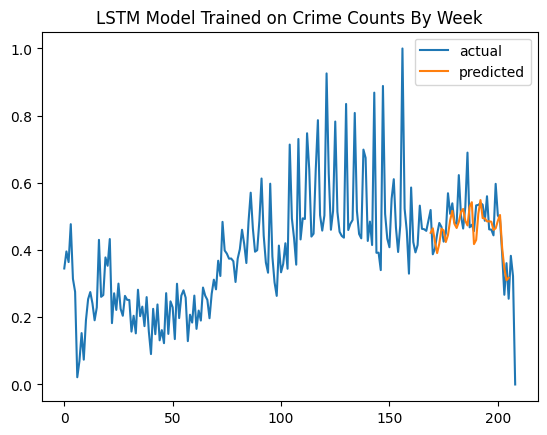

In [ ]:
#plot the true and predicted crime counts
#only predict past split_index, offset the predicted values by split_index
predictions = solo_model.predict(X[split_index:], verbose=0)[:, 0]
indices = range(split_index + 2, split_index + 2 + len(predictions))
plt.plot(time_series[:, 0], label='actual')
plt.plot(indices, predictions, label='predicted')
plt.title('LSTM Model Trained on Crime Counts By Week')
plt.legend()
plt.show()